# Model Library and Data Loading From S3

## PLEASE NOTE YOU CAN RUN THE MARKDOWN CELLS FOR YOUR REFERENCE

In [1]:
import numpy as np
import pandas as pd

import boto3
import re

import sagemaker
from sagemaker import get_execution_role
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import TransformerMixin
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
#from mlxtend.regressor import StackingRegressor

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
#from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor#, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import LocalOutlierFactor
role = get_execution_role()

role = get_execution_role()
role

!pip install xgboost==0.90

!pip install --upgrade pip

In [3]:
bucket_name = 'mysagemakerbucket' # your bucket name
raw_folder=r'houseprice/rawdata/train.csv'
s3_raw_file_location =r's3://{0}/{1}'.format(bucket_name,raw_folder)

In [4]:
raw_data=pd.read_csv(s3_raw_file_location)
raw_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
raw_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
test_data=pd.read_csv('test.csv')
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Feature Engineering

### Finding Categorical & Numerical Columns

In [7]:
num_cols = raw_data.select_dtypes(exclude='object').columns
print('{} Numeric columns \n{}'.format(len(num_cols), num_cols))

categ_cols = raw_data.select_dtypes(include='object').columns
print('\n{} Categorical columns \n{}'.format(len(categ_cols), categ_cols))

38 Numeric columns 
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

43 Categorical columns 
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtF

### Missing Values

In [8]:
df_na = (raw_data.isnull().sum()) / len(raw_data) * 100
df_na = df_na.drop(df_na[df_na==0].index).sort_values(ascending=False)
df_na.head(15)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
dtype: float64

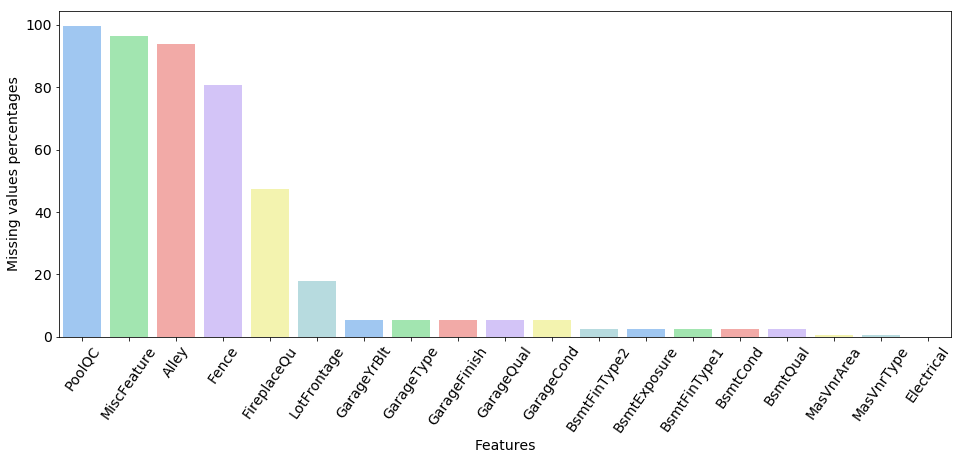

In [9]:
with plt.rc_context(rc={'font.size':14}): 
    fig, ax = plt.subplots(figsize=(16, 6))

    sns.barplot(df_na.index, df_na, palette="pastel", ax=ax)
    ax.set(xlabel='Features', ylabel='Missing values percentages')
    ax.tick_params(axis='x', rotation=55)

### Log Transformation

In [10]:
def skew_distribution(data, col='SalePrice'):
    fig, ax1 = plt.subplots()
    sns.distplot(data[col], ax=ax1, fit=stats.norm)
    (mu, sigma) = stats.norm.fit(data[col])
    ax1.set(title='Normal distribution ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma))

    fig, ax2 = plt.subplots()
    stats.probplot(data[col], plot=plt)

    print('The {} skewness is {:.2f}'.format(col, stats.skew(data[col])))

The SalePrice skewness is 1.88


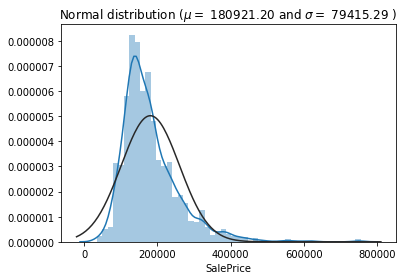

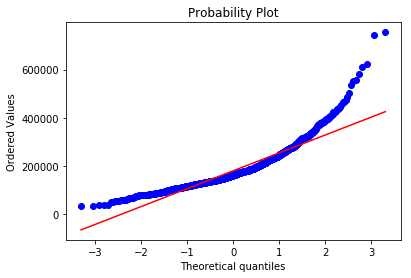

In [11]:
# distribution of the Price and fit of normal distribution
skew_distribution(raw_data, 'SalePrice')

Therefore we need to transform it into a more normal distribution since linear models will perform better.

The SalePrice skewness is 0.12


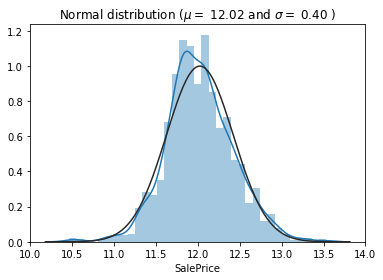

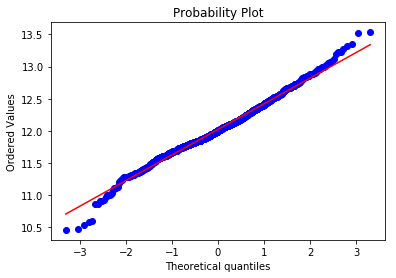

In [12]:
# After Log Transformation
raw_data['SalePrice']=np.log1p(raw_data['SalePrice'])
skew_distribution(raw_data, 'SalePrice')

SalePrice is now more gaussian and the second plot which represents the probability plot shows that the distribution follows almost a normal distribution.

### Correlation

In [13]:
corr = raw_data.corr() 
top_correlation= corr['SalePrice'].sort_values(ascending=False)[:25]
print(top_correlation)

SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
GarageYrBlt     0.541073
TotRmsAbvGrd    0.534422
Fireplaces      0.489450
MasVnrArea      0.430809
BsmtFinSF1      0.372023
LotFrontage     0.355879
WoodDeckSF      0.334135
OpenPorchSF     0.321053
2ndFlrSF        0.319300
HalfBath        0.313982
LotArea         0.257320
BsmtFullBath    0.236224
BsmtUnfSF       0.221985
BedroomAbvGr    0.209043
ScreenPorch     0.121208
Name: SalePrice, dtype: float64


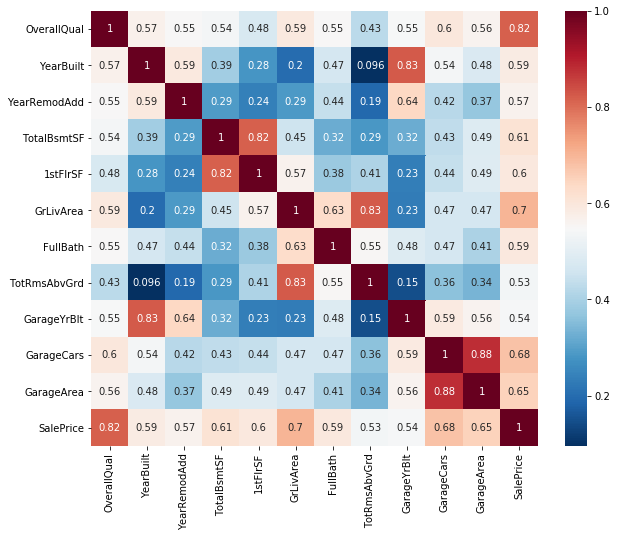

In [14]:
# Most correlated variables
threshold = 0.51
top_corr = corr.index[np.abs(corr["SalePrice"]) > threshold]

plt.figure(figsize=(10,8))
sns.heatmap(raw_data[top_corr].corr(),annot=True,cmap="RdBu_r")

In [15]:
# Inspect numeric / categorical correlated features
for col in top_correlation.index[:15]:
    print('{} - unique values: {} - mean: {:.2f}'.format(col, raw_data[col].unique()[:5], np.mean(raw_data[col])))

SalePrice - unique values: [12.24769912 12.10901644 12.31717117 11.84940484 12.4292202 ] - mean: 12.02
OverallQual - unique values: [7 6 8 5 9] - mean: 6.10
GrLivArea - unique values: [1710 1262 1786 1717 2198] - mean: 1515.46
GarageCars - unique values: [2 3 1 0 4] - mean: 1.77
GarageArea - unique values: [548 460 608 642 836] - mean: 472.98
TotalBsmtSF - unique values: [ 856 1262  920  756 1145] - mean: 1057.43
1stFlrSF - unique values: [ 856 1262  920  961 1145] - mean: 1162.63
FullBath - unique values: [2 1 3 0] - mean: 1.57
YearBuilt - unique values: [2003 1976 2001 1915 2000] - mean: 1971.27
YearRemodAdd - unique values: [2003 1976 2002 1970 2000] - mean: 1984.87
GarageYrBlt - unique values: [2003. 1976. 2001. 1998. 2000.] - mean: 1978.51
TotRmsAbvGrd - unique values: [8 6 7 9 5] - mean: 6.52
Fireplaces - unique values: [0 1 2 3] - mean: 0.61
MasVnrArea - unique values: [196.   0. 162. 350. 186.] - mean: 103.69
BsmtFinSF1 - unique values: [706 978 486 216 655] - mean: 443.64


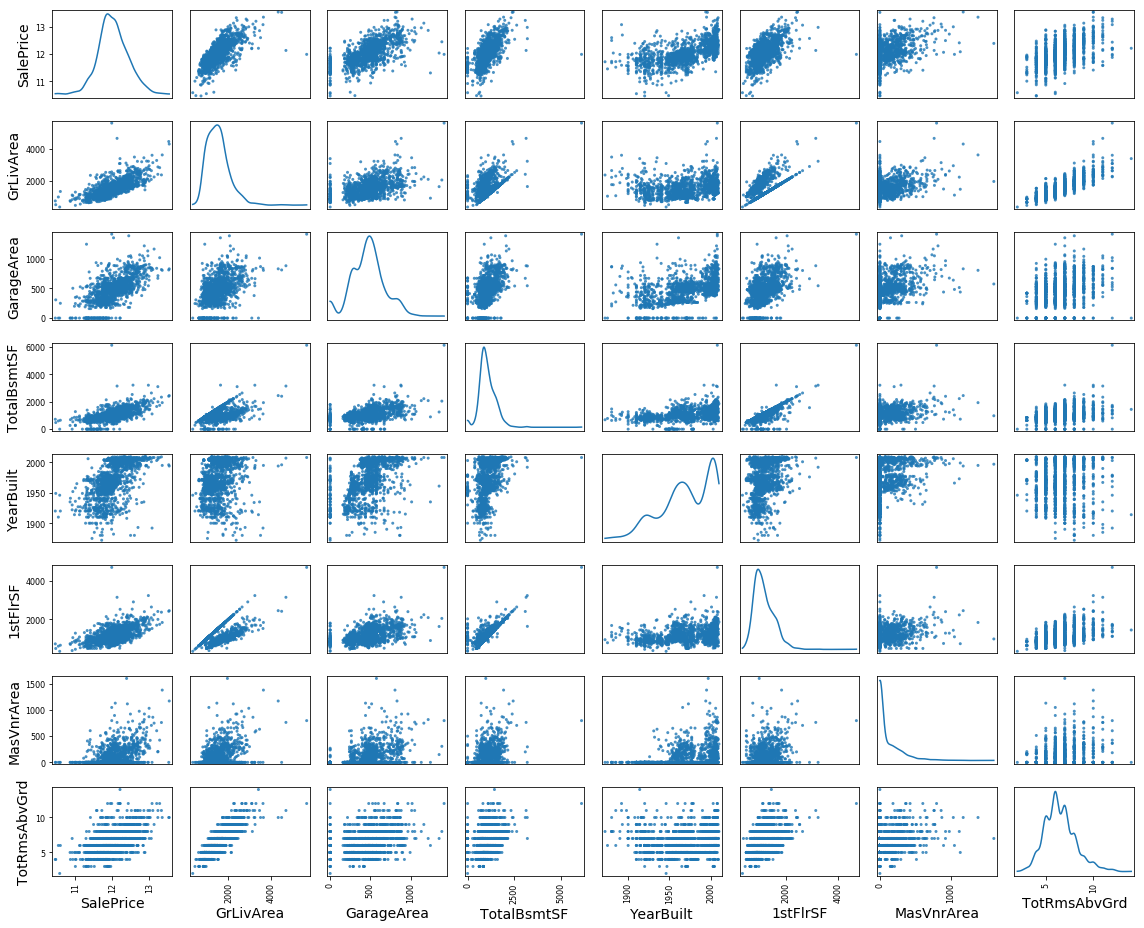

In [16]:
cols = 'SalePrice GrLivArea GarageArea TotalBsmtSF YearBuilt 1stFlrSF MasVnrArea TotRmsAbvGrd'.split()

with plt.rc_context(rc={'font.size':14}): 
    fig, ax = plt.subplots(figsize=(16,13), tight_layout=True)    
    pd.plotting.scatter_matrix(raw_data[cols], ax=ax, diagonal='kde', alpha=0.8)

These scatter plots give us some insights on a few outliers i.e. values which posses incoherent/huge values and which will impact the models. Thus, we will only remove a few of them since these ones are really important. We're gonna remove the principal outliers in the scatter plots of (GrLivRea - GarageArea - TotalBsmtSF - 1stFlrSF - MasVnrArea - TotRmsAbvGrd) vs **SalePrice**. (TODO).

### Outlier Detection

In [17]:
def detect_outliers_plots(x, y,name,top=5, plot=True):
    lof = LocalOutlierFactor(n_neighbors=40, contamination=0.1)
    x_ =np.array(x).reshape(-1,1)
    preds = lof.fit_predict(x_)
    lof_scr = lof.negative_outlier_factor_
    out_idx = pd.Series(lof_scr).sort_values()[:top].index
    if plot:
        f, ax = plt.subplots(figsize=(9, 6))
        plt.scatter(x=x, y=y, c=np.exp(lof_scr), cmap='RdBu')
        ax.set(ylabel='SalePrice', xlabel=name)
        
    return out_idx

In [18]:
outlier_ana_data=raw_data[['SalePrice','GarageArea','TotalBsmtSF', 'YearBuilt' ,'1stFlrSF','MasVnrArea', 'TotRmsAbvGrd', 'GrLivArea']]
outlier_ana_data.dropna(inplace=True)
outlier_ana_data.head()

,SalePrice,GarageArea,TotalBsmtSF,YearBuilt,1stFlrSF,MasVnrArea,TotRmsAbvGrd,GrLivArea
0,12.247699,548,856,2003,856,196.0,8,1710
1,12.109016,460,1262,1976,1262,0.0,6,1262
2,12.317171,608,920,2001,920,162.0,6,1786
3,11.849405,642,756,1915,961,0.0,7,1717
4,12.429220,836,1145,2000,1145,350.0,9,2198


Int64Index([540, 515, 1364, 318, 1158], dtype='int64')
Int64Index([1290, 331, 495, 522, 439], dtype='int64')
Int64Index([1429, 802, 800, 282, 762], dtype='int64')
Int64Index([1290, 495, 522, 1018, 1365], dtype='int64')
Int64Index([1017, 1353, 976, 378, 384], dtype='int64')
Int64Index([531, 633, 203, 1094, 612], dtype='int64')
Int64Index([1290, 522, 1176, 688, 531], dtype='int64')


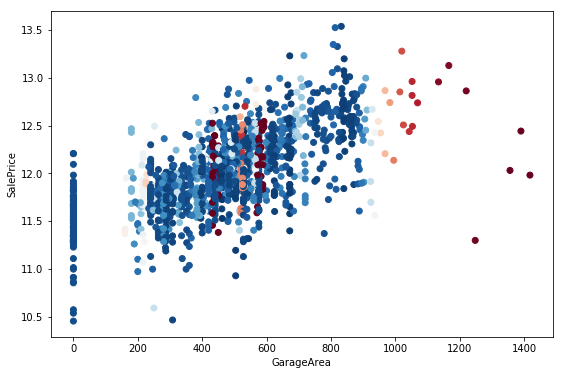

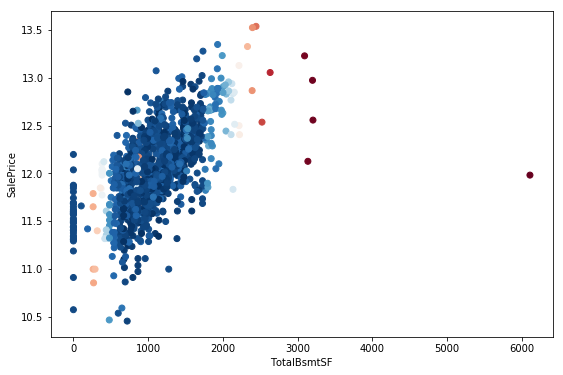

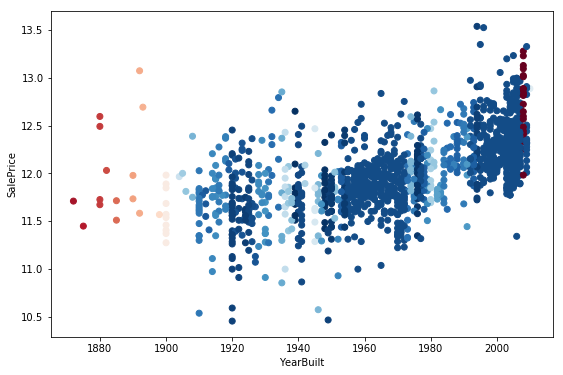

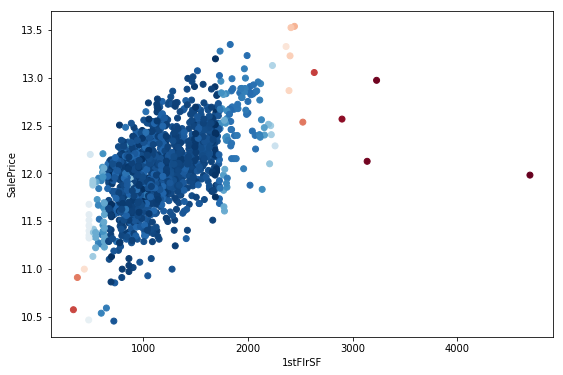

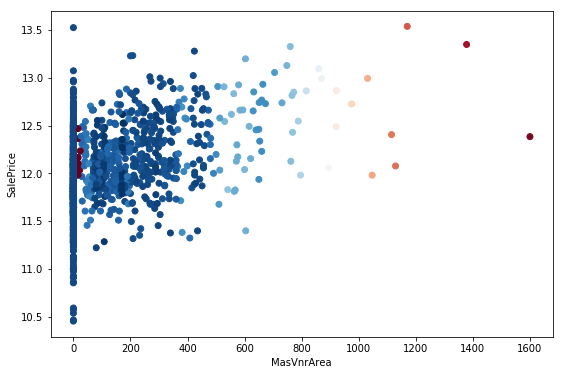

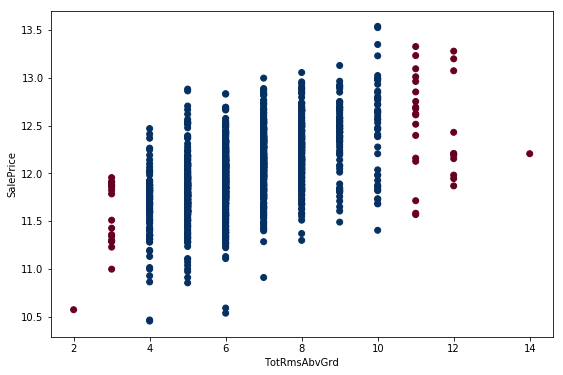

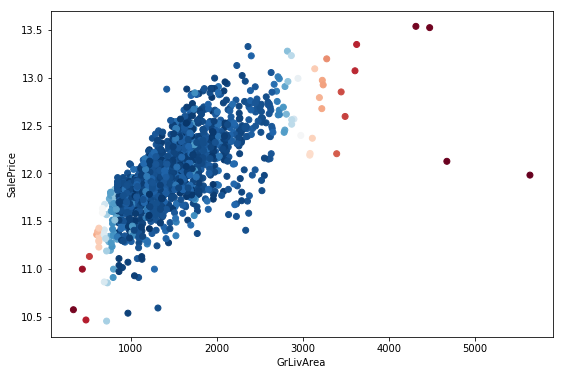

In [19]:
cols_out = ['GarageArea','TotalBsmtSF', 'YearBuilt' ,'1stFlrSF','MasVnrArea', 'TotRmsAbvGrd', 'GrLivArea']
outlier_ana_data=outlier_ana_data.dropna()
for i in cols_out:
    outs = detect_outliers_plots(outlier_ana_data[i], outlier_ana_data['SalePrice'],i,top=5) #got 1298,523
    print(outs)

In [20]:
def detect_outliers(x, y,top=5, plot=True):
    lof = LocalOutlierFactor(n_neighbors=40, contamination=0.1)
    x_ =np.array(x).reshape(-1,1)
    preds = lof.fit_predict(x_)
    lof_scr = lof.negative_outlier_factor_
    out_idx = pd.Series(lof_scr).sort_values()[:top].index
    if plot:
        f, ax = plt.subplots(figsize=(9, 6))
        plt.scatter(x=x, y=y, c=np.exp(lof_scr), cmap='RdBu')
        ax.set(ylabel='SalePrice', xlabel=name)
        
    return out_idx

In [21]:
#raw_data['SalePrice']=np.log1p(raw_data['SalePrice'])
outliers = [30, 88, 462, 523, 632, 1298, 1324]
from collections import Counter
all_outliers=[]
numeric_features = raw_data.dtypes[raw_data.dtypes != 'object'].index
for feature in numeric_features:
    try:
        outs = detect_outliers(raw_data[feature], raw_data['SalePrice'],top=5, plot=False)
    except:
        continue
    all_outliers.extend(outs)

print(Counter(all_outliers).most_common())
for i in outliers:
    if i in all_outliers:
        print(i)

[(0, 4), (533, 4), (1298, 4), (1270, 3), (375, 3), (523, 3), (635, 3), (634, 3), (976, 3), (975, 3), (978, 3), (977, 3), (313, 2), (335, 2), (916, 2), (1213, 2), (812, 2), (77, 2), (7, 2), (953, 2), (496, 2), (1182, 2), (954, 2), (597, 2), (1163, 2), (1350, 2), (1328, 2), (495, 2), (1459, 1), (1, 1), (1458, 1), (1457, 1), (164, 1), (873, 1), (589, 1), (555, 1), (249, 1), (706, 1), (451, 1), (636, 1), (1100, 1), (304, 1), (508, 1), (218, 1), (1442, 1), (1058, 1), (240, 1), (1166, 1), (591, 1), (277, 1), (771, 1), (1140, 1), (1223, 1), (699, 1), (219, 1), (229, 1), (790, 1), (930, 1), (1028, 1), (695, 1), (645, 1), (1149, 1), (125, 1), (599, 1), (574, 1), (332, 1), (440, 1), (1024, 1), (1373, 1), (431, 1), (1400, 1), (185, 1), (170, 1), (1009, 1), (88, 1), (691, 1), (738, 1), (188, 1), (326, 1), (624, 1), (298, 1), (1283, 1), (53, 1), (189, 1), (809, 1), (48, 1), (203, 1), (434, 1), (1218, 1), (642, 1), (166, 1), (309, 1), (605, 1), (1190, 1), (747, 1), (420, 1), (1340, 1), (542, 1), (13

In [22]:
Outliers_table=raw_data.loc[outliers]
#cols_out = ['GarageArea','TotalBsmtSF', 'YearBuilt' ,'1stFlrSF','MasVnrArea', 'TotRmsAbvGrd', 'GrLivArea']
Outliers_table=Outliers_table[cols_out]
Outliers_table

,GarageArea,TotalBsmtSF,YearBuilt,1stFlrSF,MasVnrArea,TotRmsAbvGrd,GrLivArea
30,250,649,1920,649,0.0,6,1317
88,0,1013,1915,1013,0.0,6,1526
462,360,864,1965,864,0.0,5,864
523,884,3138,2007,3138,762.0,11,4676
632,544,1386,1977,1411,209.0,6,1411
1298,1418,6110,2008,4692,796.0,12,5642
1324,895,1795,2006,1795,428.0,7,1795


In [23]:
#delete outliers
raw_data = raw_data.drop(raw_data.index[outliers])
raw_data.shape

(1453, 81)

In [24]:
raw_data.reset_index(drop=True, inplace=True)
raw_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220


In [26]:
r=raw_data.copy()
r.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1363
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       688
GarageType         80
GarageYrBlt        80
GarageFinish       80
GarageCars          0
GarageArea          0
GarageQual         80
GarageCond         80
PavedDrive

In [27]:
logSalesPrice=raw_data['SalePrice']
logSalesPrice.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [28]:
logSalesPrice.shape

(1453,)

So we have removed 7 rows of outliers which most common.

 ## Trend Analysis

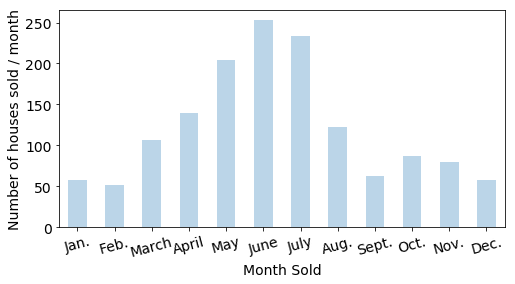

In [71]:
months = 'Jan. Feb. March April May June July Aug. Sept. Oct. Nov. Dec.'.split()
with plt.rc_context(rc={'font.size':14}): 
    fig, ax = plt.subplots(figsize=(8,4))
    raw_data.groupby('MoSold')['SalePrice'].count().plot(kind='bar', alpha=0.3, ax=ax)
    ax.set(xlabel='Month Sold', ylabel='Number of houses sold / month', 
           xticklabels=months)
    ax.tick_params(axis='x', rotation=15)

## Feature Transformation

In [72]:
sales_log= raw_data['SalePrice']
print(sales_log[:5])
#raw_data.drop(['SalePrice'], axis=1, inplace=True)
sales_log.shape

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64


(1453,)

N = List of Numeric Columns
M = 

In [29]:
N= ['GarageYrBlt', 'MasVnrArea','GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea']
M= ['MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']
S=['OverallCond','YrSold','MoSold','MSSubClass','GarageCars','Fireplaces', 'HalfBath','OverallQual']
L= ['PoolQC','MSSubClass','MasVnrType','Alley','MiscFeature','Fence','FireplaceQu','BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
cols= ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 
           'GarageQual', 'GarageCond', 'GarageFinish', 'GarageType', 
           'FireplaceQu', 'ExterQual', 'ExterCond', 
           'HeatingQC', 'PoolQC', 'KitchenQual', 
           'Functional', 'Fence', 'LandSlope',
           'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 
           'MSSubClass', 'OverallCond', 'GarageCars', 'YrSold', 'MoSold', 'Fireplaces', 'HalfBath'] 

In [30]:
def transformation(data) -> pd.DataFrame:
    for i in N:
        data[i] = data[i].fillna(0) 
    
    for i in M:
        data[i] = data[i].fillna(data[i].mode()[0]) 
    
    for i in L:
        data[i] = data[i].fillna("None") 
        
    for i in S:
        data[i] = data[i].astype(str) 
        
    data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    data["Functional"] = data["Functional"].fillna("Typ")
    data = data.drop(['Utilities'], axis=1)
    # Adding total sqfootage feature 
    return data

In [32]:
def cat_transform(data)-> pd.DataFrame():
    le = LabelEncoder() 
    for col in cols:
        data[col] = le.fit_transform(data[col])
    
    data = pd.get_dummies(data)
    
    return data

In [31]:
def add_features(data)-> pd.DataFrame():
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['GrLivArea'] + data['GarageArea']

    # Combine the bathrooms
    data['Bathrooms'] = data['FullBath'] + data['HalfBath']* 0.5 

    # Combine Year built, Garage Year Built and Year Remod 
    # (with a coeff 0.5 since it's less correlated to Year Built than the Garage year built).
    data['YearMean'] = data['YearBuilt'] + data['YearRemodAdd'] * 0.5 + data['GarageYrBlt']
    return data

In [33]:
# We don't need the Id column so we save it 
df_train_id = raw_data['Id']
df_test_id = test_data['Id']

In [34]:
print(raw_data.shape,test_data.shape)

(1453, 81) (1459, 80)


In [35]:
raw_data.drop("Id", axis=1, inplace=True)
test_data.drop("Id", axis=1, inplace=True)

In [36]:
# same transformation to the train / test datasets to avoid irregularities
size_train = len(raw_data.index)
size_test = len(test_data.index)
print((size_train),(size_test))

1453 1459


In [37]:
#y_train =sales_log #raw_data['SalePrice'].values
df_tot = pd.concat([raw_data, test_data], sort=False).reset_index(drop=True)
print(df_tot.shape)
print(df_tot.isna().sum())

(2912, 80)
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2715
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu      1418
GarageType        156
GarageYrBlt       158
GarageFinish      158
GarageCars          1
GarageArea          1
GarageQual        158
GarageCond        158

In [38]:
df_tot.drop(['SalePrice'], axis=1, inplace=True)
print(df_tot.shape)
df_tot.head()

(2912, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [39]:
print(df_tot.shape)

(2912, 79)


In [41]:
print(df_tot.shape)
df_tot = transformation(df_tot)
print(df_tot.shape)
df_tot = cat_transform(df_tot)
print(df_tot.shape)
x = df_tot[:size_train]
x=add_features(x)
print(x.shape)
x.head()


(2912, 79)
(2912, 78)
(2912, 222)
(1453, 225)


,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,TotalSF,Bathrooms,YearMean
0,10,65.0,8450,1,1,3,0,4,2003,2003,...,1,0,0,0,0,1,0,4824.0,2.5,5007.5
1,5,80.0,9600,1,1,3,0,7,1976,1976,...,1,0,0,0,0,1,0,4246.0,2.0,4940.0
2,10,68.0,11250,1,1,0,0,4,2001,2002,...,1,0,0,0,0,1,0,5100.0,2.5,5003.0
3,11,60.0,9550,1,1,0,0,4,1915,1970,...,1,1,0,0,0,0,0,4832.0,1.0,4898.0
4,10,84.0,14260,1,1,0,0,4,2000,2000,...,1,0,0,0,0,1,0,6377.0,2.5,5000.0


In [42]:
x.isna().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
Street                   0
Alley                    0
LotShape                 0
LandSlope                0
OverallCond              0
YearBuilt                0
YearRemodAdd             0
MasVnrArea               0
ExterQual                0
ExterCond                0
BsmtQual                 0
BsmtCond                 0
BsmtExposure             0
BsmtFinType1             0
BsmtFinSF1               0
BsmtFinType2             0
BsmtFinSF2               0
BsmtUnfSF                0
TotalBsmtSF              0
HeatingQC                0
CentralAir               0
1stFlrSF                 0
2ndFlrSF                 0
LowQualFinSF             0
GrLivArea                0
BsmtFullBath             0
BsmtHalfBath             0
                        ..
Heating_OthW             0
Heating_Wall             0
Electrical_FuseA         0
Electrical_FuseF         0
Electrical_FuseP         0
Electrical_Mix           0
E

In [43]:
print(x.shape)
test_data = df_tot[size_train:]
test_data.to_csv('test.csv',index=False,header=False)
test_data.head()

(1453, 225)


,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1453,5,80.0,11622,1,1,3,0,5,1961,1961,...,0,0,0,1,0,0,0,0,1,0
1454,5,81.0,14267,1,1,0,0,5,1958,1958,...,0,0,0,1,0,0,0,0,1,0
1455,10,74.0,13830,1,1,0,0,4,1997,1998,...,0,0,0,1,0,0,0,0,1,0
1456,10,78.0,9978,1,1,0,0,5,1998,1998,...,0,0,0,1,0,0,0,0,1,0
1457,0,43.0,5005,1,1,0,0,4,1992,1992,...,0,0,0,1,0,0,0,0,1,0


In [45]:
x.reset_index(drop=True, inplace=True)
x.shape

(1453, 225)

In [46]:
x.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,TotalSF,Bathrooms,YearMean
0,10,65.0,8450,1,1,3,0,4,2003,2003,...,1,0,0,0,0,1,0,4824.0,2.5,5007.5
1,5,80.0,9600,1,1,3,0,7,1976,1976,...,1,0,0,0,0,1,0,4246.0,2.0,4940.0
2,10,68.0,11250,1,1,0,0,4,2001,2002,...,1,0,0,0,0,1,0,5100.0,2.5,5003.0
3,11,60.0,9550,1,1,0,0,4,1915,1970,...,1,1,0,0,0,0,0,4832.0,1.0,4898.0
4,10,84.0,14260,1,1,0,0,4,2000,2000,...,1,0,0,0,0,1,0,6377.0,2.5,5000.0


In [47]:
x.insert(loc=0, column='SalePrice', value=logSalesPrice)
x.to_csv('house.csv')


In [48]:
x.head()

,SalePrice,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallCond,YearBuilt,...,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,TotalSF,Bathrooms,YearMean
0,12.247699,10,65.0,8450,1,1,3,0,4,2003,...,1,0,0,0,0,1,0,4824.0,2.5,5007.5
1,12.109016,5,80.0,9600,1,1,3,0,7,1976,...,1,0,0,0,0,1,0,4246.0,2.0,4940.0
2,12.317171,10,68.0,11250,1,1,0,0,4,2001,...,1,0,0,0,0,1,0,5100.0,2.5,5003.0
3,11.849405,11,60.0,9550,1,1,0,0,4,1915,...,1,1,0,0,0,0,0,4832.0,1.0,4898.0
4,12.429220,10,84.0,14260,1,1,0,0,4,2000,...,1,0,0,0,0,1,0,6377.0,2.5,5000.0


In [50]:
x.shape

(1453, 226)

# SageMaker Deployment

In [57]:
# Specify your bucket name
bucket_name = 'aniruddha-ml-sagemaker'

training_folder = r'houseprice/training/'
validation_folder = r'houseprice/validation/'
test_folder = r'houseprice/test/'

s3_model_output_location = r's3://{0}/houseprice/model'.format(bucket_name)
s3_training_file_location = r's3://{0}/{1}'.format(bucket_name,training_folder)
s3_validation_file_location = r's3://{0}/{1}'.format(bucket_name,validation_folder)
s3_test_file_location = r's3://{0}/{1}'.format(bucket_name,test_folder)

In [58]:
print(s3_model_output_location)
print(s3_training_file_location)
print(s3_validation_file_location)
print(s3_test_file_location)

s3://aniruddha-ml-sagemaker/houseprice/model
s3://aniruddha-ml-sagemaker/houseprice/training/
s3://aniruddha-ml-sagemaker/houseprice/validation/
s3://aniruddha-ml-sagemaker/houseprice/test/


In [164]:
def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [101]:
# Training = 80% of the data
# Validation = 20% of the data
# Randomize the datset
df=x.copy()
np.random.seed(5)
l = list(df.index)
np.random.shuffle(l)
df = df.loc[l]

In [102]:
rows = df.shape[0]
train = int(.20 * rows)
test = rows-train

In [103]:
# Write Training Set
df.iloc[:train].to_csv('house_train_final.csv',index=False,header=False)

In [104]:
# Write Validation Set
df.iloc[train:].to_csv('house_validation_final.csv'
                          ,index=False,header=False)

In [169]:
y.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1453,5,80.0,11622,1,1,3,0,5,1961,1961,...,0,0,0,1,0,0,0,0,1,0
1454,5,81.0,14267,1,1,0,0,5,1958,1958,...,0,0,0,1,0,0,0,0,1,0
1455,10,74.0,13830,1,1,0,0,4,1997,1998,...,0,0,0,1,0,0,0,0,1,0
1456,10,78.0,9978,1,1,0,0,5,1998,1998,...,0,0,0,1,0,0,0,0,1,0
1457,0,43.0,5005,1,1,0,0,4,1992,1992,...,0,0,0,1,0,0,0,0,1,0


In [170]:
# Write test Set
test_csv.to_csv('house_test_final.csv')

In [171]:
write_to_s3('house_train_final.csv', 
            bucket_name,
            training_folder + 'train.csv')

write_to_s3('house_validation_final.csv',
            bucket_name,
            validation_folder + 'validation.csv')

write_to_s3('house_test_final.csv',
            bucket_name,
            test_folder + 'test_tran.csv')



In [156]:
from sklearn.datasets import dump_svmlight_file

## Train Docker 

In [51]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

In [52]:
# Establish a session with AWS
sess = sagemaker.Session()

In [53]:
role = get_execution_role()

In [82]:
# Sagemaker API now maintains the algorithm container mapping for us
# Specify the region, algorithm and version
container = sagemaker.amazon.amazon_estimator.get_image_uri(
    sess.boto_region_name,
    "xgboost",
   
    )

print('Using SageMaker XGBoost container:\n{} ({})'.format(container, sess.boto_region_name))

	get_image_uri(region, 'xgboost', '0.90-1').


Using SageMaker XGBoost container:
811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1 (us-east-1)


In [83]:
# Configure the training job
# Specify type and number of instances to use
# S3 location where final artifacts needs to be stored

#   Reference: http://sagemaker.readthedocs.io/en/latest/estimators.html

estimator = sagemaker.estimator.Estimator(
    container,
    role, 
    train_instance_count=1, 
    train_instance_type='ml.m4.xlarge',
    output_path=s3_model_output_location,
    sagemaker_session=sess,
    base_job_name ='xgboost-Model')

estimator.set_hyperparameters(num_round=150,
                   max_depth=4, n_estimators=1500,
                   objective='reg:linear', random_state=28)


hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 4),
                        'colsample_bylevel':ContinuousParameter(0,1),
                        'num_round':IntegerParameter(0,150),
                    
                        'colsample_bytree':ContinuousParameter(0,.5),
                         'gamma':ContinuousParameter(0,.025),
        
                         }
#colsample_bytree, lambda, eta, max_depth, alpha, num_round, colsample_bylevel, subsample, min_child_weight, max_delta_step, gamma]
objective_metric_name = 'validation:mse'

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=2,
                            max_parallel_jobs=1)

s3_input_train = sagemaker.s3_input(s3_data=s3_training_file_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=s3_validation_file_location, content_type='csv')

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

# Tune

In [84]:
estimator.set_hyperparameters(base_score=0.5, colsample_bylevel=1,num_round=150,
                   colsample_bynode=1, colsample_bytree=0.5, 
                   learning_rate=0.02, gamma=0.025,
                   max_depth=4, n_estimators=1500, min_child_weight=2,
                   nthread=1, reg_alpha=0., reg_lambda=1, subsample=0.5, 
                   objective='reg:linear', random_state=28)

In [85]:
estimator.hyperparameters()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'num_round': 150,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'gamma': 0.025,
 'max_depth': 4,
 'n_estimators': 1500,
 'min_child_weight': 2,
 'nthread': 1,
 'reg_alpha': 0.0,
 'reg_lambda': 1,
 'subsample': 0.5,
 'objective': 'reg:linear',
 'random_state': 28}

In [86]:
z=estimator.hyperparameters()
pd.DataFrame(z.items(), columns=['Hyperparameters', 'Value'])
#pd.DataFrame(estimator.hyperparameters())

,Hyperparameters,Value
0,base_score,0.5
1,colsample_bylevel,1
2,num_round,150
3,colsample_bynode,1
4,colsample_bytree,0.5
5,learning_rate,0.02
6,gamma,0.025
7,max_depth,4
8,n_estimators,1500
9,min_child_weight,2


In [87]:
# content type can be libsvm or csv for XGBoost
training_input_config = sagemaker.session.s3_input(
    s3_data=s3_training_file_location,
    content_type='csv',
    s3_data_type='S3Prefix')

validation_input_config = sagemaker.session.s3_input(
    s3_data=s3_validation_file_location,
    content_type='csv',
    s3_data_type='S3Prefix'
)

data_channels = {'train': training_input_config, 'validation': validation_input_config}

print(training_input_config.config)
print(validation_input_config.config)

In [88]:
# XGBoost supports "train", "validation" channels
# Reference: Supported channels by algorithm
#   https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html
estimator.fit(data_channels)

2020-04-05 16:42:08 Starting - Starting the training job...
2020-04-05 16:42:09 Starting - Launching requested ML instances......
2020-04-05 16:43:12 Starting - Preparing the instances for training...
2020-04-05 16:44:06 Downloading - Downloading input data...
2020-04-05 16:44:37 Training - Downloading the training image...
2020-04-05 16:45:09 Uploading - Uploading generated training model
2020-04-05 16:45:09 Completed - Training job completed
Arguments: train
[2020-04-05:16:44:58:INFO] Running standalone xgboost training.
[2020-04-05:16:44:58:INFO] File size need to be processed in the node: 0.74mb. Available memory size in the node: 8508.11mb
[2020-04-05:16:44:58:INFO] Determined delimiter of CSV input is ','
[16:44:58] S3DistributionType set as FullyReplicated
[16:44:58] 1235x225 matrix with 277875 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-04-05:16:44:58:INFO] Determined delimiter of CSV input is ','
[16:44:58] S3DistributionType set as

# Hyperparameter tuning

In [175]:
estimator

In [ ]:
tuning_job_name = 'Hyper-Regression-tune'
sage_client = boto3.Session().client('sagemaker')

In [ ]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

In [ ]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

# Deploy

In [89]:
# Ref: http://sagemaker.readthedocs.io/en/latest/estimators.html
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.m4.xlarge',
                             endpoint_name = 'xgboost-house-v1')

---------------!

# Prediction

In [90]:
# Acquire a realtime endpoint
endpoint_name = 'xgboost-house-v1'
predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name)

In [91]:
from sagemaker.predictor import csv_serializer, json_deserializer
predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = None

In [127]:
# Need to pass an array to the prediction
# can pass a numpy array or a list of values [[19,1],[20,1]]
t=pd.read_csv("house_test_final.csv")
t=add_features(t)
t.shape
arr_test = t[t.columns[1:]].values

In [128]:
# For large number of predictions, we can split the input data and
# Query the prediction service.
# array_split is convenient to specify how many splits are needed
predictions = []
for arr in np.array_split(arr_test,50):
    result = predictor.predict(arr)
    result = result.decode("utf-8")
    result = result.split(',')
    print (arr.shape)
    predictions += [float(r) for r in result]

(30, 225)
(30, 225)
(30, 225)
(30, 225)
(30, 225)
(30, 225)
(30, 225)
(30, 225)
(30, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)
(29, 225)


In [129]:
pred=np.expm1(predictions)

In [130]:
sub=pd.DataFrame()
sub['id']=df_test_id.values
sub['SalePrice']=pred
sub.head()

,id,SalePrice
0,1461,10.459867
1,1462,7.723757
2,1463,51.396668
3,1464,68.385400
4,1465,133.739232


## Deletion Endpoint

In [119]:
sub.to_csv('sub.csv')

In [132]:
import sagemaker

sagemaker.Session().delete_endpoint(predictor.endpoint)